## Загрузка библиотек

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
## вспомогательные функции и константы
data_path = "data/"

## функция бинаризации переменной
def label_binarized(df, col):
    df = df.reset_index()
    lb_bin = LabelBinarizer()
    lb_results = lb_bin.fit_transform(df[col].astype(str))
    df = pd.concat([df, pd.DataFrame(lb_results, columns=[col + "_" + c for c in lb_bin.classes_])], axis=1)
    df.drop([col, 'index'], axis=1, inplace=True)
    return df

## метрика MSE с обратным логарифмическим преобразованием
def mean_square_error(y_true, y_pred): 
    y_pred = np.exp(y_pred)
    y_true = np.exp(y_true)
    return mean_squared_error(y_true, y_pred, squared=False)

my_scorer = make_scorer(mean_square_error, greater_is_better=False, needs_proba=False)

## Загрузка данных

In [3]:
df = pd.read_csv(data_path + "riga_re.csv")
print(df.shape)
df.head()

(4689, 13)


,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,price,lat,lon
0,For rent,Purvciems,Dzelzavas 93,1,27.0,3.0,5.0,LT proj.,Brick-Panel,All amenities,250.0,56.955484,24.202139
1,For rent,Ziepniekkalns,Ozolciema 32,2,50.0,7.0,9.0,602.,Panel,All amenities,300.0,56.899798,24.098350
2,For sale,centrs,Ieroču 6,2,33.0,1.0,2.0,P. kara,Wood,Partial amenities,13500.0,56.975092,24.139884
3,For sale,Ķengarags,Maskavas 305,2,50.0,5.0,5.0,LT proj.,Panel,All amenities,34000.0,56.859788,24.308342
4,For rent,Teika,Zemgala gatve 80,3,76.0,3.0,12.0,Jaun.,Masonry,All amenities,490.0,56.977745,24.166042


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4689 entries, 0 to 4688
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   op_type       4689 non-null   object 
 1   district      4674 non-null   object 
 2   street        4237 non-null   object 
 3   rooms         4500 non-null   object 
 4   area          4325 non-null   float64
 5   floor         4356 non-null   float64
 6   total_floors  4345 non-null   float64
 7   house_seria   4247 non-null   object 
 8   house_type    4239 non-null   object 
 9   condition     4283 non-null   object 
 10  price         4219 non-null   float64
 11  lat           4482 non-null   float64
 12  lon           4482 non-null   float64
dtypes: float64(6), object(7)
memory usage: 476.4+ KB


In [5]:
df.describe(include=[np.number])

,area,floor,total_floors,price,lat,lon
count,4325.000000,4356.000000,4345.000000,4219.000000,4482.000000,4482.000000
mean,61.204557,4.552342,6.160184,58728.706803,55.831982,22.303814
std,36.089986,8.565853,4.326098,76252.501519,3.255038,8.571356
min,1.000000,1.000000,1.000000,5.000000,46.314475,-100.708194
25%,39.000000,2.000000,5.000000,450.000000,56.936154,24.065920
50%,53.000000,3.000000,5.000000,40000.000000,56.952443,24.122890
75%,75.000000,5.000000,7.000000,82000.000000,56.963540,24.168477
max,427.000000,99.000000,99.000000,830000.000000,59.347471,24.340866


In [6]:
df.describe(include=["object"])

,op_type,district,street,rooms,house_seria,house_type,condition
count,4689,4674,4237,4500,4247,4239,4283
unique,6,51,2543,7,15,6,3
top,For sale,centrs,Kungu 25,2,P. kara,Masonry,All amenities
freq,2680,1435,25,1548,877,1322,4094


In [7]:
df.isnull().sum()

op_type           0
district         15
street          452
rooms           189
area            364
floor           333
total_floors    344
house_seria     442
house_type      450
condition       406
price           470
lat             207
lon             207
dtype: int64

## Преобработка и Анализ данных

### Целевая переменная: price

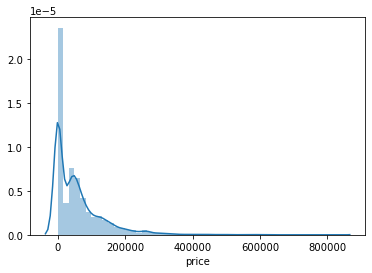

In [8]:
sns.distplot(df["price"])

In [9]:
df[df["price"].isnull()]

,op_type,district,street,rooms,area,floor,total_floors,house_seria,house_type,condition,price,lat,lon
42,Buying,Pļavnieki,NaN,Citi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.314475,11.048029
48,Buying,Ķengarags,NaN,2,NaN,12.0,7.0,NaN,NaN,All amenities,NaN,46.314475,11.048029
49,Buying,Vecmīlgrāvis,NaN,NaN,9.0,99.0,9.0,NaN,NaN,NaN,NaN,46.314475,11.048029
51,Buying,Pļavnieki,NaN,Citi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.314475,11.048029
80,Renting,Āgenskalns,NaN,4,NaN,NaN,NaN,NaN,NaN,All amenities,NaN,46.314475,11.048029
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4640,Buying,Ķengarags,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.314475,11.048029
4650,Renting,Ziepniekkalns,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.314475,11.048029
4664,Renting,Ķengarags,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.314475,11.048029
4665,Renting,Imanta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.314475,11.048029


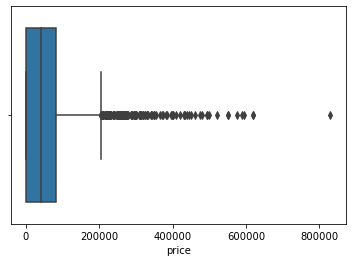

In [10]:
sns.boxplot(df["price"])

In [11]:
print(df.shape)
df = df[df["price"].notnull()]
print(df.shape)

(4689, 13)
(4219, 13)


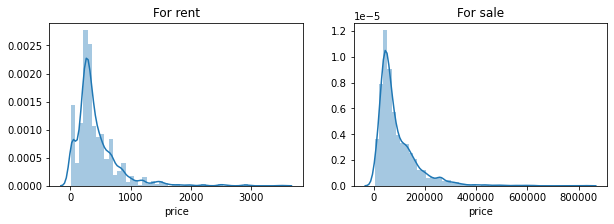

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
sns.distplot(df[df["op_type"] == "For rent"]["price"], ax=ax1).set_title('For rent')
sns.distplot(df[df["op_type"] == "For sale"]["price"], ax=ax2).set_title('For sale');

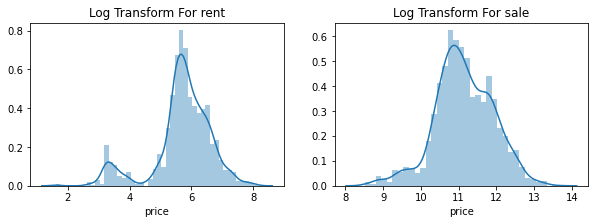

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
sns.distplot(np.log(df[df["op_type"] == "For rent"]["price"]), ax=ax1).set_title('Log Transform For rent')
sns.distplot(np.log(df[df["op_type"] == "For sale"]["price"]), ax=ax2).set_title('Log Transform For sale');

In [14]:
df.loc[:,("log_price")] = np.log(df["price"])

### Переменная: op_type

In [15]:
group = df[["op_type", "district", "price"]]\
    .groupby("op_type")\
    .agg({"price": "median", "district": "count"})\
    .reset_index()\
    .rename(columns={"price": "median_price", "district":"count_type"})
group

,op_type,median_price,count_type
0,Change,37450.0,3
1,For rent,330.0,1525
2,For sale,65000.0,2678
3,Other,175.0,5
4,Renting,500.0,5


In [16]:
df.loc[df["op_type"] == "Renting", "op_type"] = "For rent"
print(df.shape)
df = df[df["op_type"].isin(["For rent", "For sale"])]
print(df.shape)

(4219, 14)
(4210, 14)


### Переменная: district

In [17]:
print(df["district"].isnull().sum())
df = df[df["district"].notnull()]
print(df["district"].isnull().sum())

2
0


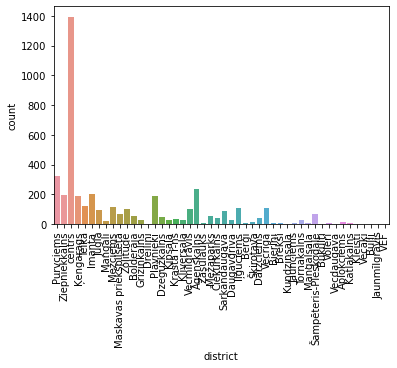

In [18]:
g = sns.countplot(df["district"])
plt.xticks(rotation=90);

In [19]:
df = label_binarized(df, "district")
df.head()

,op_type,street,rooms,area,floor,total_floors,house_seria,house_type,condition,price,...,district_Zasulauks,district_Ziepniekkalns,district_Zolitūde,district_centrs,district_Āgenskalns,district_Čiekurkalns,district_Ķengarags,district_Ķīpsala,district_Šampēteris-Pleskodāle,district_Šķirotava
0,For rent,Dzelzavas 93,1,27.0,3.0,5.0,LT proj.,Brick-Panel,All amenities,250.0,...,0,0,0,0,0,0,0,0,0,0
1,For rent,Ozolciema 32,2,50.0,7.0,9.0,602.,Panel,All amenities,300.0,...,0,1,0,0,0,0,0,0,0,0
2,For sale,Ieroču 6,2,33.0,1.0,2.0,P. kara,Wood,Partial amenities,13500.0,...,0,0,0,1,0,0,0,0,0,0
3,For sale,Maskavas 305,2,50.0,5.0,5.0,LT proj.,Panel,All amenities,34000.0,...,0,0,0,0,0,0,1,0,0,0
4,For rent,Zemgala gatve 80,3,76.0,3.0,12.0,Jaun.,Masonry,All amenities,490.0,...,0,0,0,0,0,0,0,0,0,0


### Переменная: street

In [20]:
df['street'].nunique()

2521

In [21]:
print(df["street"].isnull().sum())
df = df[df["street"].notnull()]
print(df["street"].isnull().sum())

4
0


In [22]:
df["street"].apply(lambda x: x.split()[0]).nunique()

585

In [23]:
df.drop("street", axis=1, inplace=True)

### Переменная: rooms

In [24]:
print(df["rooms"].isnull().sum())
df = df[df["rooms"].notnull()]
print(df["rooms"].isnull().sum())

1
0


In [25]:
df["rooms"].value_counts()

2       1463
3       1176
1       1079
4        351
5         94
6         26
Citi      14
Name: rooms, dtype: int64

In [26]:
df = label_binarized(df, "rooms")
print(df.shape)
df.head()

(4203, 66)


,op_type,area,floor,total_floors,house_seria,house_type,condition,price,lat,lon,...,district_Ķīpsala,district_Šampēteris-Pleskodāle,district_Šķirotava,rooms_1,rooms_2,rooms_3,rooms_4,rooms_5,rooms_6,rooms_Citi
0,For rent,27.0,3.0,5.0,LT proj.,Brick-Panel,All amenities,250.0,56.955484,24.202139,...,0,0,0,1,0,0,0,0,0,0
1,For rent,50.0,7.0,9.0,602.,Panel,All amenities,300.0,56.899798,24.098350,...,0,0,0,0,1,0,0,0,0,0
2,For sale,33.0,1.0,2.0,P. kara,Wood,Partial amenities,13500.0,56.975092,24.139884,...,0,0,0,0,1,0,0,0,0,0
3,For sale,50.0,5.0,5.0,LT proj.,Panel,All amenities,34000.0,56.859788,24.308342,...,0,0,0,0,1,0,0,0,0,0
4,For rent,76.0,3.0,12.0,Jaun.,Masonry,All amenities,490.0,56.977745,24.166042,...,0,0,0,0,0,1,0,0,0,0


## Переменные: floor, total_floors

In [27]:
df["floor"].value_counts()

2.0     935
1.0     735
3.0     730
5.0     593
4.0     586
6.0     248
9.0     105
7.0     101
8.0      80
12.0     21
10.0     19
11.0      9
15.0      7
14.0      6
21.0      6
16.0      5
17.0      5
13.0      4
20.0      3
23.0      2
18.0      2
24.0      1
Name: floor, dtype: int64

In [28]:
df["total_floors"].value_counts()

5.0     1499
9.0      615
6.0      569
4.0      383
3.0      299
2.0      298
7.0      178
12.0      90
10.0      55
1.0       47
8.0       42
16.0      32
24.0      24
30.0      18
23.0      12
18.0      10
11.0       8
17.0       6
25.0       6
13.0       5
15.0       2
22.0       2
29.0       1
14.0       1
27.0       1
Name: total_floors, dtype: int64

In [29]:
df["flag_first_floor"] = np.where((df["floor"] == 1) & (df["floor"] == 2), 1, 0)
df["flag_last_floor"] = np.where(df["total_floors"] == df["floor"], 1, 0)

## Переменная: house_seria, house_type

In [30]:
df["house_seria"].value_counts()

P. kara     870
Jaun.       811
Renov.      549
Specpr.     395
LT proj.    384
602.        282
Hrušč.      250
119.        147
Staļina     130
M. ģim.     127
103.         77
467.         69
Priv. m.     44
104.         35
Čehu pr.     33
Name: house_seria, dtype: int64

In [31]:
df = label_binarized(df, "house_seria")
df.head()

,op_type,area,floor,total_floors,house_type,condition,price,lat,lon,log_price,...,house_seria_Hrušč.,house_seria_Jaun.,house_seria_LT proj.,house_seria_M. ģim.,house_seria_P. kara,house_seria_Priv. m.,house_seria_Renov.,house_seria_Specpr.,house_seria_Staļina,house_seria_Čehu pr.
0,For rent,27.0,3.0,5.0,Brick-Panel,All amenities,250.0,56.955484,24.202139,5.521461,...,0,0,1,0,0,0,0,0,0,0
1,For rent,50.0,7.0,9.0,Panel,All amenities,300.0,56.899798,24.098350,5.703782,...,0,0,0,0,0,0,0,0,0,0
2,For sale,33.0,1.0,2.0,Wood,Partial amenities,13500.0,56.975092,24.139884,9.510445,...,0,0,0,0,1,0,0,0,0,0
3,For sale,50.0,5.0,5.0,Panel,All amenities,34000.0,56.859788,24.308342,10.434116,...,0,0,1,0,0,0,0,0,0,0
4,For rent,76.0,3.0,12.0,Masonry,All amenities,490.0,56.977745,24.166042,6.194405,...,0,1,0,0,0,0,0,0,0,0


In [32]:
df["house_type"].value_counts()

Masonry        1318
Panel          1195
Brick           856
Brick-Panel     436
Panel-Brick     206
Wood            192
Name: house_type, dtype: int64

In [33]:
df = label_binarized(df, "house_type")
df.head()

,op_type,area,floor,total_floors,condition,price,lat,lon,log_price,district_Aplokciems,...,house_seria_Renov.,house_seria_Specpr.,house_seria_Staļina,house_seria_Čehu pr.,house_type_Brick,house_type_Brick-Panel,house_type_Masonry,house_type_Panel,house_type_Panel-Brick,house_type_Wood
0,For rent,27.0,3.0,5.0,All amenities,250.0,56.955484,24.202139,5.521461,0,...,0,0,0,0,0,1,0,0,0,0
1,For rent,50.0,7.0,9.0,All amenities,300.0,56.899798,24.098350,5.703782,0,...,0,0,0,0,0,0,0,1,0,0
2,For sale,33.0,1.0,2.0,Partial amenities,13500.0,56.975092,24.139884,9.510445,0,...,0,0,0,0,0,0,0,0,0,1
3,For sale,50.0,5.0,5.0,All amenities,34000.0,56.859788,24.308342,10.434116,0,...,0,0,0,0,0,0,0,1,0,0
4,For rent,76.0,3.0,12.0,All amenities,490.0,56.977745,24.166042,6.194405,0,...,0,0,0,0,0,0,1,0,0,0


### Переменная: condition

In [34]:
df["condition"].value_counts()

All amenities        4018
Partial amenities     172
Without amenities      13
Name: condition, dtype: int64

In [35]:
df = label_binarized(df, "condition")
df.head()

,op_type,area,floor,total_floors,price,lat,lon,log_price,district_Aplokciems,district_Berģi,...,house_seria_Čehu pr.,house_type_Brick,house_type_Brick-Panel,house_type_Masonry,house_type_Panel,house_type_Panel-Brick,house_type_Wood,condition_All amenities,condition_Partial amenities,condition_Without amenities
0,For rent,27.0,3.0,5.0,250.0,56.955484,24.202139,5.521461,0,0,...,0,0,1,0,0,0,0,1,0,0
1,For rent,50.0,7.0,9.0,300.0,56.899798,24.098350,5.703782,0,0,...,0,0,0,0,1,0,0,1,0,0
2,For sale,33.0,1.0,2.0,13500.0,56.975092,24.139884,9.510445,0,0,...,0,0,0,0,0,0,1,0,1,0
3,For sale,50.0,5.0,5.0,34000.0,56.859788,24.308342,10.434116,0,0,...,0,0,0,0,1,0,0,1,0,0
4,For rent,76.0,3.0,12.0,490.0,56.977745,24.166042,6.194405,0,0,...,0,0,0,1,0,0,0,1,0,0


In [36]:
df.isnull().sum()

op_type                        0
area                           0
floor                          0
total_floors                   0
price                          0
                              ..
house_type_Panel-Brick         0
house_type_Wood                0
condition_All amenities        0
condition_Partial amenities    0
condition_Without amenities    0
Length: 89, dtype: int64

### Переменная: lat, lon

In [37]:
print(df[["lat", "lon"]].isnull().sum())
df = df.loc[(df["lat"].notnull()),:]
print(df[["lat", "lon"]].isnull().sum())

lat    206
lon    206
dtype: int64
lat    0
lon    0
dtype: int64


## Моделирование

In [38]:
df_rent = df.loc[(df["op_type"] == "For rent"),:]
df_rent.drop("op_type", axis=1, inplace=True)

df_sale = df.loc[(df["op_type"] == "For sale"),:]
df_sale.drop("op_type", axis=1, inplace=True)

print(df_rent.shape, df_sale.shape)

(1451, 88) (2546, 88)


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [39]:
print(df_rent["price"].describe())
Q1 = df_rent["price"].quantile(0.05)
Q2 = df_rent["price"].quantile(0.95)
Q1, Q2

count    1451.000000
mean      421.306685
std       365.605554
min         5.000000
25%       225.000000
50%       330.000000
75%       520.000000
max      3500.000000
Name: price, dtype: float64


(30.0, 1075.0)

(1451, 88)
(1312, 88)
count    1312.000000
mean      376.681402
std       217.327206
min        30.000000
25%       230.000000
50%       324.500000
75%       500.000000
max      1050.000000
Name: price, dtype: float64


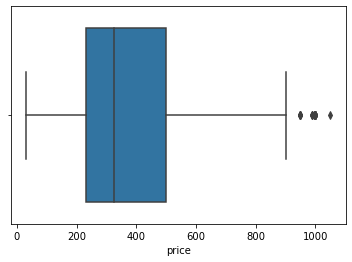

In [40]:
print(df_rent.shape)
df_rent = df_rent[(df_rent["price"] >= Q1) & (df_rent["price"] <= Q2)]
print(df_rent.shape)
print(df_rent["price"].describe())
sns.boxplot(df_rent["price"])

In [41]:
print(df_sale["price"].describe())
Q1 = df_sale["price"].quantile(0.05)
Q2 = df_sale["price"].quantile(0.95)
Q1, Q2

count      2546.000000
mean      92492.193637
std       78132.227920
min        5000.000000
25%       43000.000000
50%       66250.000000
75%      120000.000000
max      830000.000000
Name: price, dtype: float64


(18000.0, 250000.0)

(2546, 88)
(2301, 88)
count      2301.000000
mean      84025.778357
std       51358.607272
min       18000.000000
25%       45000.000000
50%       66990.000000
75%      115000.000000
max      250000.000000
Name: price, dtype: float64


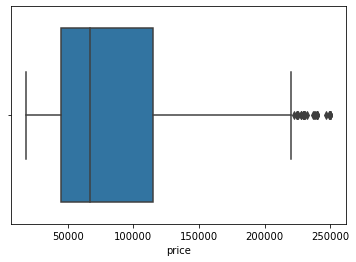

In [42]:
print(df_sale.shape)
df_sale = df_sale[(df_sale["price"] >= Q1) & (df_sale["price"] <= Q2)]
print(df_sale.shape)
print(df_sale["price"].describe())
sns.boxplot(df_sale["price"])

In [43]:
df_rent.drop("price", axis=1, inplace=True)
df_sale.drop("price", axis=1, inplace=True)

In [44]:
X = df_rent.drop("log_price", axis=1)
y = df_rent["log_price"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [45]:
rf = RandomForestRegressor(n_estimators=2000, max_depth=6, max_features="auto")
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
mean_square_error(y_test, y_pred)

160.37812082606052

In [46]:
pickle.dump(rf, open("data/model_for_rent.pickle", 'wb'))

In [47]:
X = df_sale.drop("log_price", axis=1)
y = df_sale["log_price"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [48]:
rf = RandomForestRegressor(n_estimators=2000, max_depth=6, max_features="auto")
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
mean_square_error(y_test, y_pred)

23337.312359380863

In [49]:
pickle.dump(rf, open("data/model_for_sale.pickle", 'wb'))

### Создадим шалон для предсказаний

In [50]:
x_test.head()

,area,floor,total_floors,lat,lon,district_Aplokciems,district_Berģi,district_Bieriņi,district_Bolderāja,district_Brekši,...,house_seria_Čehu pr.,house_type_Brick,house_type_Brick-Panel,house_type_Masonry,house_type_Panel,house_type_Panel-Brick,house_type_Wood,condition_All amenities,condition_Partial amenities,condition_Without amenities
1337,48.0,2.0,5.0,56.859788,24.308342,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1923,112.0,2.0,4.0,56.918403,24.088300,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1680,52.0,3.0,4.0,56.965707,24.142105,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2015,67.0,2.0,6.0,56.971682,24.102195,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2478,67.2,7.0,9.0,56.941229,24.217423,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [51]:
template = x_test.head(1)
for col in template.columns:
    template.loc[:,(col)] = 0
template.to_csv("data/template.csv", index=False)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Сохраним данные для каэжого из сегментов для отображения на карте

In [55]:
df_sale["price"] = np.exp(df_sale["log_price"])
pickle.dump(df_sale, open("data/df_sale.pickle", 'wb'))

In [56]:
df_rent["price"] = np.exp(df_rent["log_price"])
pickle.dump(df_rent, open("data/df_rent.pickle", 'wb'))

In [61]:
val = 100000
df_sale.iloc[(df_sale['price']-val).abs().values.argsort()[:10]]

,area,floor,total_floors,lat,lon,log_price,district_Aplokciems,district_Berģi,district_Bieriņi,district_Bolderāja,...,house_type_Brick,house_type_Brick-Panel,house_type_Masonry,house_type_Panel,house_type_Panel-Brick,house_type_Wood,condition_All amenities,condition_Partial amenities,condition_Without amenities,price
3508,56.1,1.0,4.0,56.965062,24.195293,11.512925,0,0,0,0,...,0,1,0,0,0,0,1,0,0,100000.0
3620,58.0,5.0,5.0,56.948717,24.102601,11.512925,0,0,0,0,...,0,0,1,0,0,0,1,0,0,100000.0
1444,59.0,2.0,5.0,56.951796,24.126306,11.512925,0,0,0,0,...,0,0,1,0,0,0,1,0,0,100000.0
1744,50.0,2.0,4.0,56.968951,24.144884,11.512925,0,0,0,0,...,0,0,1,0,0,0,1,0,0,100000.0
1945,91.0,3.0,5.0,56.946133,24.173175,11.512925,0,0,0,0,...,0,1,0,0,0,0,1,0,0,100000.0
52,96.0,3.0,6.0,56.957953,24.142512,11.512925,0,0,0,0,...,0,0,1,0,0,0,1,0,0,100000.0
1148,86.0,6.0,7.0,56.981337,24.187762,11.511925,0,0,0,0,...,1,0,0,0,0,0,1,0,0,99900.0
2451,51.0,2.0,9.0,56.951413,24.003876,11.511915,0,0,0,0,...,0,0,0,1,0,0,1,0,0,99899.0
328,67.0,9.0,30.0,56.933500,24.042485,11.511675,0,0,0,0,...,0,0,1,0,0,0,1,0,0,99875.0
2357,65.0,2.0,4.0,56.914968,24.122890,11.511324,0,0,0,0,...,0,0,0,0,1,0,1,0,0,99840.0
